In [ ]:
!pip install deepctr-torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 1.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from deepctr_torch.inputs import SparseFeat, get_feature_names
from deepctr_torch.models import DeepFM
from sklearn.metrics import mean_absolute_error
import numpy as np


In [ ]:
# 구글 드라이브 내 데이터가 위치한 경로를 설정합니다.
path = '/content/drive/MyDrive/Yeradream/'

# 학습용 데이터 파일
data = pd.read_csv(f'{path}Data/Train_Data.csv', encoding='utf-8')

# 평가용 데이터 파일
test = pd.read_csv(f'{path}Data/Test.csv', encoding='utf-8')

# 제출용 파일
submit = pd.read_csv(f'{path}Data/Sample_Submission.csv', encoding='utf-8')

cpu
Train on 5316 samples, validate on 1329 samples, 21 steps per epoch
Epoch 1/15
0s - loss:  14.4591 - mse:  14.4193 - val_mse:  10.9183
Epoch 2/15
0s - loss:  6.7601 - mse:  6.7156 - val_mse:  2.4233
Epoch 3/15
0s - loss:  1.1146 - mse:  1.1143 - val_mse:  0.8457
Epoch 4/15
0s - loss:  0.7684 - mse:  0.7676 - val_mse:  0.6853
Epoch 5/15
0s - loss:  0.6465 - mse:  0.6470 - val_mse:  0.6526
Epoch 6/15
0s - loss:  0.5687 - mse:  0.5685 - val_mse:  0.6342
Epoch 7/15
0s - loss:  0.4815 - mse:  0.4817 - val_mse:  0.6244
Epoch 8/15
0s - loss:  0.3993 - mse:  0.3989 - val_mse:  0.6302
Epoch 9/15
0s - loss:  0.3327 - mse:  0.3327 - val_mse:  0.6516
Epoch 10/15
1s - loss:  0.2877 - mse:  0.2882 - val_mse:  0.6753
Epoch 11/15
0s - loss:  0.2564 - mse:  0.2560 - val_mse:  0.7037
Epoch 12/15
0s - loss:  0.2341 - mse:  0.2344 - val_mse:  0.7272
Epoch 13/15
0s - loss:  0.2175 - mse:  0.2177 - val_mse:  0.7484
Epoch 14/15
0s - loss:  0.2050 - mse:  0.2050 - val_mse:  0.7684
Epoch 15/15
0s - loss:  

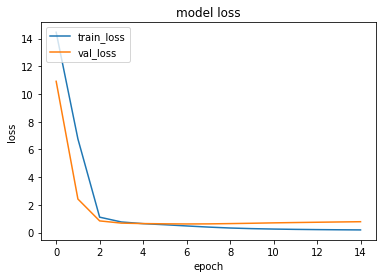

Valid MAE 0.6534


In [ ]:
# 학습에 활용할 모든 Column
ALL_FIELDS = ['식당ID','평점','좋아요 수','리뷰_작성자']
# 연속형 변수가 담긴 Column
CONT_FIELDS = ['평점','좋아요 수']
# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS))
sparse_features = CAT_FIELDS
# One Hot Encoding
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
# 맞추고자 하는 Y Target 설정
target = ['총평']


# Count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# Trains set과 Valid Set으로 분리
train, valid = train_test_split(data, test_size=0.2)
train_model_input = {name: train[name] for name in feature_names}
valid_model_input = {name: valid[name] for name in feature_names}

# gpu 사용이 가능하면 GPU 사용 설정
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device,dnn_dropout=0.5)
# Adam Optimizer와 MSE Error 설정 및 학습
model.compile("adam", "mse", metrics=['mse'])
history = model.fit(train_model_input,train[target].values,batch_size=256,epochs=15,verbose=2,validation_split=0.2)

# 모델 결과 출력
plt.plot(history.history["loss"])
plt.plot(history.history["val_mse"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"], loc="upper left")
plt.show()

pred_ans = model.predict(valid_model_input, batch_size=256)
# 평점은 정수이므로 반올림하여 정수화
pred_ans = np.around(pred_ans)

print("Valid MAE", round(mean_absolute_error(valid[target].values, pred_ans), 4))
# 모델 및 Weight 저장
torch.save(model, 'DeepFM.h5')
torch.save(model.state_dict(), 'DeepFM_weights.h5')

In [ ]:
model = torch.load('DeepFM.h5')
model.load_state_dict(torch.load('DeepFM_weights.h5'))

Test_Data = pd.read_csv('/content/drive/MyDrive/Yeradream/Data/Test.csv',encoding='utf-8')

ALL_FIELDS = ['식당ID','평점','좋아요 수','리뷰_작성자']
CONT_FIELDS = ['평점','좋아요 수']
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS))
target = ['총평']

sparse_features = CAT_FIELDS

fixlen_feature_columns = [SparseFeat(feat, Test_Data[feat].nunique())for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

for feat in sparse_features:
    lbe = LabelEncoder()
    Test_Data[feat] = lbe.fit_transform(Test_Data[feat])

fixlen_feature_columns = [SparseFeat(feat, Test_Data[feat].nunique()) for feat in sparse_features]

test_input = {name: Test_Data[name] for name in feature_names}
pred_ans = model.predict(test_input, batch_size=256)
pred_ans = np.around(pred_ans)
print("test MAE", round(mean_absolute_error(Test_Data[target].values, pred_ans), 4))

Baseline_Submission = Test_Data[['총평','Answer_ID']]
Baseline_Submission['총평'] = pred_ans
Baseline_Submission.to_csv('Baseline_Submission.csv',encoding='utf-8')

test MAE 3.9283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
pred_ans

array([[5.],
       [4.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [4.],
       [5.],
       [4.],
       [4.],
       [4.],
       [3.],
       [5.],
       [5.],
       [3.],
       [5.],
       [4.],
       [4.],
       [4.],
       [3.],
       [4.],
       [4.],
       [4.],
       [3.],
       [4.],
       [3.],
       [3.],
       [4.],
       [4.],
       [5.],
       [5.],
       [4.],
       [4.],
       [3.],
       [5.],
       [4.],
       [4.],
       [2.],
       [4.],
       [3.],
       [4.],
       [3.],
       [5.],
       [4.],
       [5.],
       [3.],
       [4.],
       [6.],
       [4.],
       [4.],
       [6.],
       [4.],
       [5.],
       [5.],
       [4.],
       [5.],
       [4.],
       [4.],
       [2.],
       [6.],
       [4.],
       [3.],
       [4.],
       [3.],
       [4.],
       [5.],
       [3.],
       [4.],
       [4.],
       [4.],
       [3.],
       [4.],
       [5.],
       [5.],